# ROI GLMs

In [107]:
import nideconv
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns
sns.set(style="whitegrid", font_scale=1)
# from jupyterthemes import jtplot
# jtplot.style('onedork')

import sys
import os
import pickle as pkl

import glob
import re

from nilearn import masking, plotting
import nibabel as nib

# many future warnings here, these can be annoying
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

# Statistics
from scipy import stats
from statsmodels.sandbox.stats import multicomp

## Utility functions

In [96]:
def get_event_data(subject_id, session, run, bids_root='./data/deriv/fmriprep', 
                   event_types=('go_trial', 'successful_stop', 'failed_stop'),
                   get_jitters=True, drop_duplicates=True):
    """ Loads all event data """
    import pandas

    if session in ['optcomb', 'me', 'PAID', 'echo_1', 'echo_2', 'echo_3', 'me-den']:
        session = 'me'
    fn = os.path.join(bids_root, 'sub-' + subject_id, 'ses-' + session, 
                      'func', 'sub-{}_ses-{}_task-stop_run-{}_events.tsv'.format(subject_id, session, run))
    df = pandas.read_csv(fn, sep='\t')

    # Since many subjects do not have errors and we want the design matrices to be the same(did I write this??)
    # across subjects, we only look at correct trials
    if event_types is not None:
        to_return = df[np.in1d(df.trial_type, event_types)].fillna(0.1)
    else:
        to_return = df

    if drop_duplicates:
        # drop duplicates (double responses on a single trial)
        to_return = to_return.drop_duplicates('onset')
    return to_return

def get_all_ts(sub, ses, run):
    if ses == 'se':
        dat = pd.read_csv('./deconvolution_cache/sub-{}_ses-se_run-{}_all_ts.tsv'.format(str(sub).zfill(2), run), sep='\t')
    elif ses in ['optcomb', 'PAID']:
        dat = pd.read_csv('./deconvolution_cache/sub-{}_ses-me_run-{}_comb-{}_all_ts.tsv'.format(str(sub).zfill(2), run, ses), sep='\t')
    elif 'echo_' in ses:
        dat = pd.read_csv('./deconvolution_cache/sub-{}_ses-me_run-{}_echo-{}_all_ts.tsv'.format(str(sub).zfill(2), run, ses[-1]), sep='\t')
    elif ses == 'me-den':
        dat = pd.read_csv('./deconvolution_cache/sub-{}_ses-me-den_run-{}_comb-optcomb_all_ts.tsv'.format(str(sub).zfill(2), run), sep='\t')
    return dat

def get_session_timeseries(ses, standardize='zscore', override_runs=None, drop_label=True):
    dfs = []
    for sub in range(1,19):
        if sub == 12:
            continue
        elif sub == 17:
            runs = [1,2]
        else:
            runs = [1,2,3]
        sub = str(sub).zfill(2)
        
        if override_runs is not None:
            runs = override_runs
            if runs[0] == 3 and sub == 17:
                continue

        for run in runs:
            ts = get_all_ts(sub, ses, run)
            
            # set on common scale across runs
            if standardize == 'psc':
                ts = ts.apply(lambda x: x/np.mean(x) * 100 - 100, axis=0)
            elif standardize == 'zscore':
                ts = ts.apply(lambda x: (x-np.mean(x)) / np.std(x), axis=0)
                
            ts['subject'] = sub
            ts['run'] = run
            if drop_label:
                ts.drop(labels='time', axis=1, inplace=True)
            dfs.append(ts)
            
    all_dat = pd.concat(dfs)
    all_dat['session'] = ses
    all_dat = all_dat.set_index(['subject', 'session', 'run'])
    return all_dat

def get_all_onsets(ses, event_types=('go_trial', 'failed_stop', 'successful_stop', 'response_left', 'response_right')):
    onset_dfs = []
    for sub in range(1,19):
        if sub == 12:
            continue
        elif sub == 17:
            runs = [1,2]
        else:
            runs = [1,2,3]
        sub = str(sub).zfill(2)

        for run in runs:
            onsets_this_run = get_event_data(sub, ses, run, event_types=event_types)
            onsets_this_run['subject'] = sub
            onsets_this_run['session'] = ses
            onset_dfs.append(onsets_this_run)

    onsets = pd.concat(onset_dfs)
    onsets = onsets.loc[onsets.trial_type.isin(event_types),
                        ['subject', 'session', 'run', 'trial_type', 'onset', 'duration', 'response_time']]
    onsets = onsets.set_index(['subject', 'session', 'run'])
    return onsets

In [97]:
def plot_single_mask_timecourses(rfGroup, data_type,
                                 mask_name, oversample=100, plot_type='first_level',
                                 event_types=('go_trial', 'failed_stop', 'successful_stop'),
                                 ax=None, legend='brief', add_sigma2=False):
    
    if ax is None:
        f, ax = plt.subplots(11)
        
    if data_type == 't':
        ## plot t-values
        if rfGroup.concatenate_runs:
            rfs = rfGroup._get_response_fitters(concatenate_runs=True)
            t_ = rfs.apply(lambda rf: rf.get_t_value_timecourses(oversample))
            t = pd.concat(t_.to_dict())
            index_names = t_.index.names
            t.index.set_names(index_names, level=range(len(index_names)), inplace=True)
            tc_3 = t['t'].reset_index()[['subject', 'event type', 'time', mask_name]]
            
        else:
            tc = rfGroup.get_t_value_timecourses(oversample=oversample, concatenate_runs=rfGroup.concatenate_runs).t
            tc = tc[mask_name].reset_index()

            # mean over runs
            tc_2 = tc.reset_index().rename(columns={"level_0": 'subject', 'level_1': 'session', 'level_2': 'run'})
            tc_3 = tc_2.pivot_table(values=mask_name, index=['subject', 'session', 'event type', 'time']).reset_index()
        sns.lineplot(x='time', y=mask_name, hue='event type', hue_order=event_types, data=tc_3, legend=legend, ax=ax,
                     ci=67)
    elif data_type == 'psc':
        ## plot psc or z-scores
#        group_rf = rfGroup[data_type]
        tc = rfGroup.get_subjectwise_timecourses(oversample=oversample, melt=True)
        
        if plot_type == 'first_level':
            tc = tc.loc[np.in1d(tc['event type'], event_types)]
            
            sns.lineplot(x='time', y='value', hue='event type', hue_order=event_types, 
                         data=tc.loc[tc['roi']==mask_name], 
                         legend=legend, ax=ax, ci=67)

#             sns.tsplot(data=tc.loc[tc['roi']==mask_name], 
#                        time='time', unit='subject', 
#                        condition='event type', value='value', 
#                        ax=ax, legend=legend)
        else:
            tc = tc.loc[tc.roi==mask_name]
            tc = tc.loc[np.in1d(tc['event type'], ('go_trial', 'failed_stop', 'successful_stop'))]
            tc = tc.pivot_table(values='value', index=['subject', 'time', 'covariate'], columns='event type').reset_index()
            tc['failed_stop - go_trial'] = tc['failed_stop'] - tc['go_trial']
            tc['failed_stop - successful_stop'] = tc['failed_stop'] - tc['successful_stop']
            tc['successful_stop - go_trial'] = tc['successful_stop'] - tc['go_trial']
            tc = tc.melt(id_vars=['subject', 'time'], value_vars=['failed_stop - go_trial', 'failed_stop - successful_stop', 'successful_stop - go_trial'])
            sns.lineplot(x='time', y='value', hue='event type', data=tc, legend=legend, ax=ax)
    elif data_type == 't-level2':
        tc = rfGroup.get_subjectwise_timecourses(oversample=oversample, melt=True)
        tc = tc.loc[np.in1d(tc['event type'], event_types)]
        
        # t-test
        t_vals = tc.groupby(['event type', 'roi', 'time'])['value'].apply(lambda x: stats.ttest_1samp(x, 0)[0]).reset_index()
        sns.lineplot(data=t_vals.loc[t_vals['roi']==mask_name], 
                     x='time', hue='event type', y='value', 
                     ax=ax, legend=legend)
    elif data_type == 'snr-level2':
        tc = rfGroup.get_subjectwise_timecourses(oversample=oversample, melt=True)
        tc = tc.loc[np.in1d(tc['event type'], event_types)]
        
        # t-test
        vals = tc.groupby(['event type', 'roi', 'time'])['value'].apply(lambda x: x.mean()/x.std()).reset_index()
        sns.lineplot(data=vals.loc[vals['roi']==mask_name], 
                     x='time', hue='event type', y='value', 
                     ax=ax, legend=legend, hue_order=event_types)
    
    if add_sigma2:
        sigma2 = rfGroup._get_response_fitters().apply(lambda x: x.sigma2)[mask_name]
        t = ax.text(.95, .95, '$\sigma^2 = {}\pm{}$'.format(np.mean(sigma2).round(2), np.std(sigma2).round(2)),
                     horizontalalignment='right',
                     verticalalignment='top',
                     transform = ax.transAxes)
        t.set_bbox(dict(facecolor='white', alpha=1.0, edgecolor='grey'))
        
    ax.axhline(y=0, c='k', ls='--')
    ax.axvline(x=0, c='k', ls='--')
    
from matplotlib import gridspec
    
def make_plot(plot_dict, data_type, columns, masks, oversample=100, plot_type='first_level', 
              y_label='% signal change', event_types=('failed_stop', 'go_trial', 'successful_stop'),
              column_titles=None, add_sigma2=False, sharey='row'):
    
    if len(columns) == 5 and not sharey == 'row':
        width_ratios = [1, 0.1, 1, 0.3, 1, .1, 1, .1, 1]
    else:
        width_ratios = [1, .15] * (len(columns)-1) + [1]
    gridspec_kws = dict(hspace=0.1, wspace=0.0, 
                        width_ratios=width_ratios)
    f, axes = plt.subplots(len(masks), len(width_ratios), gridspec_kw=gridspec_kws)

    columns_to_populate = np.arange(len(columns), dtype=int)*2
    empty_columns = [x for x in np.arange(len(width_ratios)) if not x in columns_to_populate]
    for col in empty_columns:
        for row in range(len(masks)):
            axes[row, col].axis('off')
    
#     f, axes = plt.subplots(len(masks), len(columns))
    if len(axes.shape) == 1:
        axes = axes[np.newaxis,:]

#     ax = f.add_subplot(111, frameon=False)
#     # hide tick and tick label of the big axes
# #     ax.axis('off')
#     ax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
#     ax.spines["left"].set_visible(False)
#     ax.spines["top"].set_visible(False)
#     ax.spines["right"].set_visible(False)
#     ax.spines["bottom"].set_visible(False)
#     ax.set_ylabel(y_label)
#     # ax.set_xlabel('Time from trial onset (s)')
#     ax.yaxis.labelpad = 30
#    fig.text(0.5, 0.04, 'common X', ha='center')
    f.text(0.05, 0.5, y_label, va='center', rotation='vertical')#, labelpad=30)

    # for titles: https://stackoverflow.com/questions/40936729/matplotlib-title-spanning-two-or-any-number-of-subplot-columns
    ext = []
    # loop over the columns (j) and rows(i) to populate subplots
    for j in range(len(axes[0,:])):
        # save the axes bounding boxes for later use
        ext.append([axes[0,j].get_window_extent().x0, axes[0,j].get_window_extent().width])

    # make nice
    inv = f.transFigure.inverted()
    width_left = ext[0][0]+(ext[columns_to_populate.max()][0]+ext[columns_to_populate.max()][1]-ext[0][0])/2.
    left_center = inv.transform( (width_left, 1) )

    # set column spanning title 
    # the first two arguments to figtext are x and y coordinates in the figure system (0 to 1)
    plt.figtext(left_center[0], .1, "Time from trial onset (s)", va="center", ha="center")

    # plot
    for row, mask in enumerate(masks):
        print(mask, end='')
        for col_n, session_name in zip(columns_to_populate, columns):
    
            if isinstance(oversample, list):
                oversample_ = oversample[col_n]
            else:
                oversample_ = oversample
            print('.', end='')
            plot_single_mask_timecourses(plot_dict[session_name],
                                         data_type=data_type,
                                         mask_name=mask, 
                                         ax=axes[row,col_n], 
                                         plot_type=plot_type,
                                         oversample=oversample_,
                                         event_types=event_types,
                                         add_sigma2=add_sigma2)
            if col_n > 0:
                axes[row, col_n].set_ylabel('')
            # remove xlabels except bottom row
#             if row < (len(masks)-1):
            axes[row, col_n].set_xlabel('')
        axes[row,0].set_ylabel(mask)

        if sharey == 'row':
            # get maximum ylims, set
            current_ranges = np.array([np.array(x.get_ylim()) for x in axes[row,:]])
            for ax in axes[row,:]:
                ax.set_ylim(current_ranges.min(0)[0], current_ranges.max(0)[1])
        else:
            for sharey_columns in sharey:
                sharey_columns = [x*2 for x in sharey_columns]
                # get maximum ylims, set
                current_ranges = np.array([np.array(x.get_ylim()) for x in axes[row, sharey_columns]])
                for ax in axes[row, sharey_columns]:
                    ax.set_ylim(current_ranges.min(0)[0], current_ranges.max(0)[1])

    # Add column titles
    if column_titles is None:
        column_titles = columns
    
    for col_n, col_name in zip(columns_to_populate, column_titles):
        axes[0, col_n].set_title(col_name.replace('_', ' '))

    if plot_type == 'contrasts':
        labels = ["Failed stop - go", "Failed stop - successful stop", "Successful stop - go"]
    else:
        labels = ['Failed stop', 'Go', 'Successful stop']
        
    # remove legends except first
    for row_n in range(len(masks)):
        for col_n in columns_to_populate:
            if col_n == 4 and row_n == 0:
                axes[row_n, col_n].legend(handles=axes[row_n, col_n].lines, 
                                          labels=labels,
                                          loc=9, ncol=3, bbox_to_anchor=(.5, 1.4))
#                 axes[row_n, col_n].legend_.set_bbox_to_anchor((1, 1), transform=axes[row_n, col_n].transAxes)
            else:
                axes[row_n, col_n].legend_.remove()
    
    # determine where to place/remove ticks on y-axis
    if sharey == 'row':
        keep_y_ticks = [0]
    else:
        keep_y_ticks = [x[0]*2 for x in sharey]
        
    # hide ticks/values on axes
    for col in np.arange(1, columns_to_populate.max()+1):
        if col in keep_y_ticks:
            labelleft = 'On'
        else:
            labelleft = 'Off'

        for row in range(0, len(masks)-1):
            axes[row, col].tick_params(top='off', right='off', labelbottom='Off', labelleft=labelleft)

        # for bottom row, keep bottom labels
        axes[len(masks)-1,col].tick_params(top='off', right='off', labelleft=labelleft)

    for row in range(0, len(masks)-1):
#        axes[row, -1].tick_params(top='off', right='off', labelbottom='Off')
        for col in keep_y_ticks:
            axes[row, col].tick_params(top='off', right='off', labelbottom='Off')
    

    f.set_size_inches(len(columns)*4, len(masks)*3)
    return f, axes

In [98]:
ses_ts = {'se': {'psc': get_session_timeseries('se', standardize='psc'),
                 'zscore': get_session_timeseries('se', standardize='zscore')},
          'optcomb': {'psc': get_session_timeseries('optcomb', standardize='psc'),
                      'zscore': get_session_timeseries('optcomb', standardize='zscore')},
          'echo_1': {'psc': get_session_timeseries('echo_1', standardize='psc'),
                     'zscore': get_session_timeseries('echo_1', standardize='zscore')},
          'echo_2': {'psc': get_session_timeseries('echo_2', standardize='psc'),
                     'zscore': get_session_timeseries('echo_2', standardize='zscore')},
          'echo_3': {'psc': get_session_timeseries('echo_3', standardize='psc'),
                     'zscore': get_session_timeseries('echo_3', standardize='zscore')}}


## Fit canonical HRF with temporal derivative

In [99]:
# get motion parameters as confounds
def get_confounds_timeseries(ses, standardize='psc', override_runs=None):
    dfs = []
    for sub in range(1,19):
        if sub == 12:
            continue
        elif sub == 17:
            runs = [1,2]
        else:
            runs = [1,2,3]
        sub_str = str(sub).zfill(2)
        
        if override_runs is not None:
            runs = override_runs
            if runs[0] == 3 and sub == 17:
                continue

        for run in runs:
            if ses == 'se':
                ts = pd.read_csv('./data/deriv/fmriprep/sub-{}/ses-se/func/sub-{}_ses-se_task-stop_run-{}_desc-confounds_regressors.tsv'.format(sub_str, sub_str, run), sep='\t')
            elif ses == 'optcomb':
                ts = pd.read_csv('./data/deriv/fmriprep/sub-{}/ses-me/func/sub-{}_ses-me_task-stop_run-{}_echo-1_desc-confounds_regressors.tsv'.format(sub_str, sub_str, run), sep='\t')
            elif 'echo' in ses:
                echo_n = ses[-1]
                ts = pd.read_csv('./data/deriv/fmriprep/sub-{}/ses-me/func/sub-{}_ses-me_task-stop_run-{}_echo-{}_desc-confounds_regressors.tsv'.format(sub_str, sub_str, run, echo_n), sep='\t')
                                
            ts['subject'] = sub_str
            ts['run'] = run
            if 'time' in ts.columns:
                ts.drop(labels='time', axis=1, inplace=True)
            dfs.append(ts)
            
    all_dat = pd.concat(dfs)
    all_dat['session'] = ses
    all_dat = all_dat.set_index(['subject', 'session', 'run'])
    return all_dat

In [100]:
##
rfGroupsCwD = {'psc': {}, 'zscore': {}}
masks = ['rSTN', 'lSTN', 'rSTR', 'lSTR', 'lGPe', 'rGPe', 'lPreSMA', 'rPreSMA', 'rM1', 'rIFG']
for ses in ['se', 'optcomb', 'echo_1', 'echo_2', 'echo_3']:
    print('Data: {}...'.format(ses), end='')
    onsets = get_all_onsets(ses=ses, event_types=('go_trial', 'successful_stop', 'failed_stop'))
    # NB: slice time correction references to TR/2, not to 0; shift onsets to align timesereis and events
    onsets['onset'] -= 1.5
    
    # exclude trials with RT > 1
    onsets['rt'] = onsets['response_time'] - onsets['onset'] - 1.5
    onsets = onsets.loc[~((onsets['rt'] > 1) & (onsets['trial_type'] != 'successful_stop'))]
    del onsets['duration']
    del onsets['response_time']
    del onsets['rt']

    for standardization in rfGroupsCwD.keys():
        print('{}...'.format(standardization), end='')
        # get relevant data
        ts = ses_ts[ses][standardization]
        confounds = get_confounds_timeseries(ses)[['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'framewise_displacement']]
        confounds = confounds.reset_index()
        
        # deconvolve
        rfGroup = nideconv.GroupResponseFitter(ts, onsets, 1/3., confounds=confounds,
                                               oversample_design_matrix=20)
        rfGroup.add_event(interval=[0,18], basis_set='canonical_hrf_with_time_derivative', type='ar(1)')
        rfGroup.fit(store_residuals=True)

        rfGroupsCwD[standardization][ses] = rfGroup

Data: se...psc...

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2843: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


zscore...

Data: optcomb...psc...

zscore...

Data: echo_1...psc...

zscore...

Data: echo_2...psc...

zscore...

Data: echo_3...psc...

zscore...

rM1.....rPreSMA.....rIFG.....rSTR.....rGPe.....rGPi.....rSTN.....

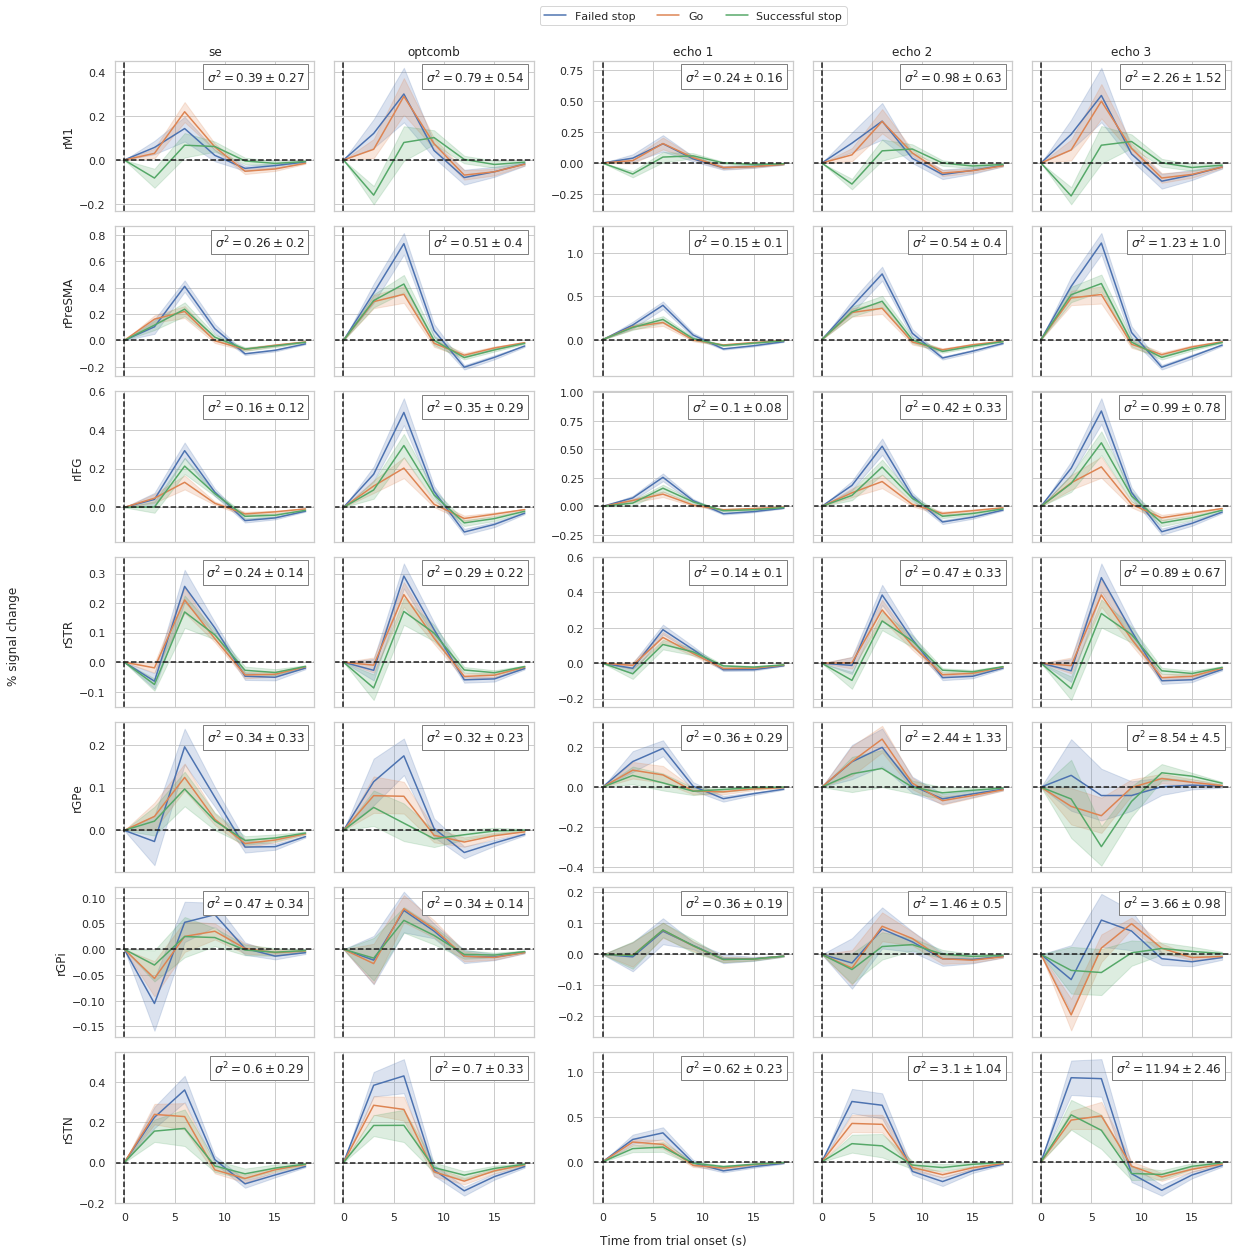

In [101]:
columns = ['se', 'optcomb', 'echo_1', 'echo_2', 'echo_3']
plot_masks = ['rM1', 'rPreSMA', 'rIFG', 'rSTR', 'rGPe', 'rGPi', 'rSTN']

f, ax = make_plot(plot_dict=rfGroupsCwD['psc'],
                  y_label='% signal change',
                  columns=columns, 
                  masks=plot_masks, 
                  data_type='psc', 
                  oversample=1,
                  plot_type='first_level',
                  add_sigma2=True,
                  sharey=[(0, 1), (2, 3, 4)])

# Comparison of first-level $t$-values between protocols

In [102]:
def get_t_vals(rfGroup, data_type='se', contrast_type='first_level'):
    """ Extract t-values (PEs, PE variance) from rfGroup-object """
    contrasts = {}
    if contrast_type == 'first_level':
        if data_type == 'se':
            contrasts['Successful stop'] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
            contrasts['Failed stop'] =     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
            contrasts['Go'] =              [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
        else:
            contrasts['Successful stop'] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
            contrasts['Failed stop'] =     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
            contrasts['Go'] =              [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
    else:
        if data_type == 'se':
            contrasts['Failed stop - go'] =              [0, 0, 0, 0, 0, 0, 0, 0, -1, 0,  0, 0, 1, 0]
            contrasts['Failed stop - successful stop'] = [0, 0, 0, 0, 0, 0, 0, 0,  0, 0, -1, 0, 1, 0]
            contrasts['Successful stop - go'] =          [0, 0, 0, 0, 0, 0, 0, 0, -1, 0,  1, 0, 0, 0]
        else:
            contrasts['Failed stop - go'] =              [0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 1, 0,  0, 0]
            contrasts['Failed stop - successful stop'] = [0, 0, 0, 0, 0, 0, 0, 0,  0, 0, 1, 0, -1, 0]
            contrasts['Successful stop - go'] =          [0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0,  1, 0]

    pes = []
    var_pes = []
    ts = []
    for c_name, c_vector in contrasts.items():
        pe = rfGroup._get_response_fitters().apply(lambda x: estimate_cope(x, c_vector))
        var_pe = rfGroup._get_response_fitters().apply(lambda x: estimate_varcope(x, c_vector))
        t = pe / np.sqrt(var_pe)
        
        pe['Event'] = c_name
        var_pe['Event'] = c_name
        t['Event'] = c_name
        
        pes.append(pe)
        var_pes.append(var_pe)
        ts.append(t)

    return pd.concat(pes), pd.concat(var_pes), pd.concat(ts)
    
def estimate_varcope(response_fitter, C):
    ## Estimate variance of PE
    X = response_fitter.X
    sigma2 = np.std(response_fitter._residuals)**2
    
    varcope = sigma2*np.dot(np.dot(C, np.linalg.pinv(np.dot(X.T, X))), C)
    return varcope

def estimate_cope(response_fitter, C):
    ## Get PE
    X = response_fitter.X
    Y = response_fitter.input_signal
    XtXinv = np.linalg.pinv(np.dot(X.T, X))
    XY = np.dot(X.T, Y)
    copes = np.dot(C, np.dot(XtXinv, XY))
    return pd.Series(copes, index=response_fitter.input_signal.columns)

In [105]:
# get first-level t-values for the single echo, optimally combined multi echo data, and per echo
pe_se, var_se, t_se = get_t_vals(rfGroupsCwD['psc']['se'], data_type='se')
pe_oc, var_oc, t_oc = get_t_vals(rfGroupsCwD['psc']['optcomb'], data_type='oc')
pe_e1, var_e1, t_e1 = get_t_vals(rfGroupsCwD['psc']['echo_1'], data_type='e1')
pe_e2, var_e2, t_e2 = get_t_vals(rfGroupsCwD['psc']['echo_2'], data_type='e2')
pe_e3, var_e3, t_e3 = get_t_vals(rfGroupsCwD['psc']['echo_3'], data_type='e3')

# Add name to data frames
t_se['Data'] = 'Single echo'
t_oc['Data'] = 'Multi echo (OC)'
t_e1['Data'] = 'Echo 1'
t_e2['Data'] = 'Echo 2'
t_e3['Data'] = 'Echo 3'

pe_se['Data'] = 'Single echo'
pe_oc['Data'] = 'Multi echo (OC)'
pe_e1['Data'] = 'Echo 1'
pe_e2['Data'] = 'Echo 2'
pe_e3['Data'] = 'Echo 3'

# Add contrasts
pe_se_contrast, var_se_contrast, t_se_contrast = get_t_vals(rfGroupsCwD['psc']['se'], data_type='se', contrast_type='contrast')
pe_oc_contrast, var_oc_contrast, t_oc_contrast = get_t_vals(rfGroupsCwD['psc']['optcomb'], data_type='oc', contrast_type='contrast')
pe_e1_contrast, var_e1_contrast, t_e1_contrast = get_t_vals(rfGroupsCwD['psc']['echo_1'], data_type='e1', contrast_type='contrast')
pe_e2_contrast, var_e2_contrast, t_e2_contrast = get_t_vals(rfGroupsCwD['psc']['echo_2'], data_type='e2', contrast_type='contrast')
pe_e3_contrast, var_e3_contrast, t_e3_contrast = get_t_vals(rfGroupsCwD['psc']['echo_3'], data_type='e3', contrast_type='contrast')

t_se_contrast['Data'] = 'Single echo'
t_oc_contrast['Data'] = 'Multi echo (OC)'
t_e1_contrast['Data'] = 'Echo 1'
t_e2_contrast['Data'] = 'Echo 2'
t_e3_contrast['Data'] = 'Echo 3'

pe_se_contrast['Data'] = 'Single echo'
pe_oc_contrast['Data'] = 'Multi echo (OC)'
pe_e1_contrast['Data'] = 'Echo 1'
pe_e2_contrast['Data'] = 'Echo 2'
pe_e3_contrast['Data'] = 'Echo 3'

# Concatenate everything into pd.DataFrames
pes = pd.concat([pe_se, pe_oc, pe_e1, pe_e2, pe_e3, pe_se_contrast, pe_oc_contrast, pe_e1_contrast, pe_e2_contrast, pe_e3_contrast])
t_vals = pd.concat([t_se, t_oc, t_e1, t_e2, t_e3, t_se_contrast, t_oc_contrast, t_e1_contrast, t_e2_contrast, t_e3_contrast])

# Make them "long" instead of "wide"
pes_long = pes.reset_index().melt(id_vars=['subject', 'Data', 'Event'], var_name='ROI', value_name='pe')
t_vals_long = t_vals.reset_index().melt(id_vars=['subject', 'Data', 'Event'], var_name='ROI', value_name='t')

pes_long.head()

,subject,Data,Event,ROI,pe
0,01,Single echo,Successful stop,ACC,0.022605
1,02,Single echo,Successful stop,ACC,0.236305
2,03,Single echo,Successful stop,ACC,0.377199
3,04,Single echo,Successful stop,ACC,0.085016
4,05,Single echo,Successful stop,ACC,0.357018


#### Calculate differences in t-values between the single echo and multi echo data

In [106]:
def get_protocol_differences(x, dv='t'):
    se_oc = x.loc[x['Data'] == 'Single echo', dv].values - x.loc[x['Data'] == 'Multi echo (OC)', dv].values
    
    return pd.Series({'Single echo - Multi echo': se_oc[0]})

t_differences = t_vals_long.groupby(['Event', 'subject', 'ROI']).apply(get_protocol_differences, dv='t').reset_index()

# Only test right-lateralized ROIs
t_differences = t_differences.loc[np.in1d(t_differences.ROI, plot_masks)]

# def get_protocol_differences_echos(x, dv='t'):
#     e1_e2 = x.loc[x['Data'] == 'Echo 1', dv].values - x.loc[x['Data'] == 'Echo 2', dv].values
#     e1_e3 = x.loc[x['Data'] == 'Echo 1', dv].values - x.loc[x['Data'] == 'Echo 3', dv].values
#     e2_e3 = x.loc[x['Data'] == 'Echo 2', dv].values - x.loc[x['Data'] == 'Echo 3', dv].values
    
#     return pd.Series({'Echo 1 - Echo 2': e1_e2[0],
#                       'Echo 1 - Echo 3': e1_e3[0],
#                       'Echo 2 - Echo 3': e2_e3[0]
#                       })

# pe_differences = pes_long.groupby(['Data', 'subject', 'ROI']).apply(get_contrast_differences, dv='pe').reset_index()
# t_differences_echo = t_vals_long.groupby(['Event', 'subject', 'ROI']).apply(get_protocol_differences_echos, dv='t').reset_index()

# Only test right-lateralized ROIs
# pe_differences = pe_differences.loc[np.in1d(pe_differences.ROI, plot_masks)]
# t_differences_echo = t_differences_echo.loc[np.in1d(t_differences_echo.ROI, plot_masks)]

#### Statistical test: Are the $t$-values significantly different between protocols?

1. For the regressors vs baseline

In [273]:
# Overall test: Repeated measures ANOVA
from statsmodels.stats.anova import AnovaRM
to_test = t_vals_long
to_test['t'] = np.abs(to_test['t'])  # make t-value absolute
to_test = to_test.loc[(np.in1d(to_test.Data, ['Single echo', 'Multi echo (OC)'])) &
                      (np.in1d(to_test.ROI, ['rM1', 'rIFG', 'rPreSMA', 'rSTR', 'rGPe', 'rGPi', 'rSTN']))]

anova = AnovaRM(data=to_test.loc[(np.in1d(to_test.Event, ['Go', 'Failed stop', 'Successful stop'])) &
                                 (np.in1d(to_test.Data, ['Single echo', 'Multi echo (OC)'])) &
                                 (np.in1d(to_test.ROI, ['rM1', 'rIFG', 'rPreSMA', 'rSTR', 'rGPe', 'rGPi', 'rSTN']))], 
                depvar='t', subject='subject', within=['Data', 'ROI', 'Event'])
res = anova.fit()
res_table = res.summary().tables[0]
p_vals = res_table.iloc[:,-1]
res_table.iloc[:,-1] = multicomp.fdrcorrection0(p_vals)[1]
res_table.round(3)

,Num DF,Den DF,F Value,Pr > F
Data,1.0,16.0,0.050,0.826
ROI,6.0,96.0,13.845,0.000
Event,2.0,32.0,15.637,0.000
Data:ROI,6.0,96.0,2.998,0.017
Data:Event,2.0,32.0,0.483,0.817
ROI:Event,12.0,192.0,5.860,0.000
Data:ROI:Event,12.0,192.0,0.751,0.817


So no main effect of Data (=protocol), but a Data\*ROI interaction. We follow-up on that below, but first, the second AnovaRM with..

2. the contrasts

In [281]:
# Overall test: Repeated measures ANOVA
from statsmodels.stats.anova import AnovaRM
to_test = t_vals_long
to_test['t'] = np.abs(to_test['t'])  # make t-value absolute
to_test = to_test.loc[(np.in1d(to_test.Data, ['Single echo', 'Multi echo (OC)'])) &
                      (np.in1d(to_test.ROI, ['rM1', 'rIFG', 'rPreSMA', 'rSTR', 'rGPe', 'rGPi', 'rSTN']))]

anova = AnovaRM(data=to_test.loc[(np.in1d(to_test.Event, ['Failed stop - go', 'Failed stop - successful stop', 'Successful stop - go'])) &
                                 (np.in1d(to_test.Data, ['Single echo', 'Multi echo (OC)'])) &
                                 (np.in1d(to_test.ROI, ['rM1', 'rIFG', 'rPreSMA', 'rSTR', 'rGPe', 'rGPi', 'rSTN']))], 
                depvar='t', subject='subject', within=['Data', 'ROI', 'Event'])
res = anova.fit()
res_table = res.summary().tables[0]
p_vals = res_table.iloc[:,-1]
res_table.iloc[:,-1] = multicomp.fdrcorrection0(p_vals)[1]
res_table.round(3)

,Num DF,Den DF,F Value,Pr > F
Data,1.0,16.0,0.135,0.718
ROI,6.0,96.0,11.633,0.000
Event,2.0,32.0,9.428,0.001
Data:ROI,6.0,96.0,2.890,0.022
Data:Event,2.0,32.0,2.381,0.152
ROI:Event,12.0,192.0,9.783,0.000
Data:ROI:Event,12.0,192.0,0.882,0.660


In [276]:
# Follow-up paired t-tests
t_statistics = t_differences_long.groupby(['Event', 'ROI', 'Contrast'])['Value'].apply(lambda x: pd.Series({'t': stats.ttest_1samp(x, popmean=0)[0],
                                                                                             'p': stats.ttest_1samp(x, popmean=0)[1]}))
t_statistics = t_statistics.reset_index().pivot_table(values='Value', index=['Event', 'ROI', 'Contrast'], columns='level_3').reset_index()

# Correct for multiple comparisons, separate for regressors against baseline, and contrasts
p_vals_t_regressor = t_statistics.loc[np.in1d(t_statistics.Event, ['Failed stop', 'Go', 'Successful stop'])]
p_vals_t_contrasts = t_statistics.loc[np.in1d(t_statistics.Event, ['Failed stop - successful stop', 'Failed stop - go', 'Successful stop - go'])]
p_vals_t_regressor['p_corrected'] = multicomp.fdrcorrection0(p_vals_t_regressor['p'])[1]
p_vals_t_contrasts['p_corrected'] = multicomp.fdrcorrection0(p_vals_t_contrasts['p'])[1]

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [277]:
print("After MC correction, the following $t$-values of regressors against baseline are significantly different between protocols:")
display(p_vals_t_regressor.loc[p_vals_t_regressor['p_corrected'] < 0.05])

print("Without MC correction, the following $t$-values of regressors against baseline are significantly different between protocols:")
display(p_vals_t_regressor.loc[p_vals_t_regressor['p'] < 0.05])

After MC correction, the following $t$-values of regressors against baseline are significantly different between protocols:


level_3,Event,ROI,Contrast,p,t,p_corrected


Without MC correction, the following $t$-values of regressors against baseline are significantly different between protocols:


level_3,Event,ROI,Contrast,p,t,p_corrected
4,Failed stop,rPreSMA,Single echo - Multi echo,0.018688,-2.616880,0.130819
21,Go,rGPe,Single echo - Multi echo,0.012428,2.815842,0.130497
28,Successful stop,rGPe,Single echo - Multi echo,0.036923,2.276313,0.193846
32,Successful stop,rPreSMA,Single echo - Multi echo,0.003830,-3.378506,0.080429


In [278]:
print("After MC correction, the following $t$-values of contrasts are significantly different between protocols:")
display(p_vals_t_contrasts.loc[p_vals_t_contrasts['p_corrected'] < 0.05])

print("Without MC correction, the following $t$-values of contrasts are significantly different between protocols:")
display(p_vals_t_contrasts.loc[p_vals_t_contrasts['p'] < 0.05])

After MC correction, the following $t$-values of contrasts are significantly different between protocols:


level_3,Event,ROI,Contrast,p,t,p_corrected


Without MC correction, the following $t$-values of contrasts are significantly different between protocols:


level_3,Event,ROI,Contrast,p,t,p_corrected
11,Failed stop - go,rPreSMA,Single echo - Multi echo,0.027239,-2.430017,0.572029


#### Create figure 5

In [120]:
# load (from whole-brain GLM analysis): zmaps, thresholds
import pickle as pkl
with open('glm_figure_axes/zmaps.pkl', 'rb') as f:
    zmaps_combined = pkl.load(f)

with open('glm_figure_axes/thresholds.pkl', 'rb') as f:
    thresholds_combined = pkl.load(f)
    
from nilearn import plotting

bg_img = '/home/stevenm/Templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'

from utils import get_roi_dict, add_contours, get_prop_limits
roi_map = get_roi_dict()

In [121]:
from functools import partial

plot_spm = partial(plotting.plot_stat_map, 
                   bg_img=bg_img, display_mode='y', cut_coords=[-13], 
                   colorbar=None, annotate=False, vmax=6)

def add_rois(disp, roi_dict):
    plot_rois = ['rIFG', 'M1',
             'lSTR', 'lGPe', 'lGPi', 'lSTN',
             'rSTR', 'rGPe', 'rGPi', 'rSTN']
    for roi_ in plot_rois:
        roi_map = roi_dict[roi_]
        add_contours(disp, roi=roi_map['fn'], thr=roi_map['threshold'], color=roi_map['color'])

def fix_lims(disp, display_mode='y'):
    # determine limits (xlim/ylim) based on first column, and apply to all others
    this_key = list([x for x in disp.axes.keys()])[0]
    # Determine new xlim/ylim
    cur_xlim = disp.axes[this_key].ax.get_xlim()
    cur_ylim = disp.axes[this_key].ax.get_ylim()
    if display_mode == 'x':
        new_xlim = get_prop_limits([0, 1], cur_xlim)
        new_ylim = get_prop_limits([0, 1], cur_ylim)
    elif display_mode == 'z' and 'STN' in roi:
        new_xlim = get_prop_limits([.25, .75], cur_xlim)
        new_ylim = get_prop_limits([.40, .90], cur_ylim)
    elif display_mode == 'z' and 'STR' in roi:
        new_xlim = get_prop_limits([0, 1], cur_xlim)
        new_ylim = get_prop_limits([0.3, 1], cur_ylim)
    elif display_mode == 'y':
        new_xlim = get_prop_limits([.26, .74], cur_xlim)
        new_ylim = get_prop_limits([.25, .75], cur_ylim)

    # Change axes limits
    disp.axes[this_key].ax.set_xlim(new_xlim[0], new_xlim[1])
    disp.axes[this_key].ax.set_ylim(new_ylim[0], new_ylim[1])

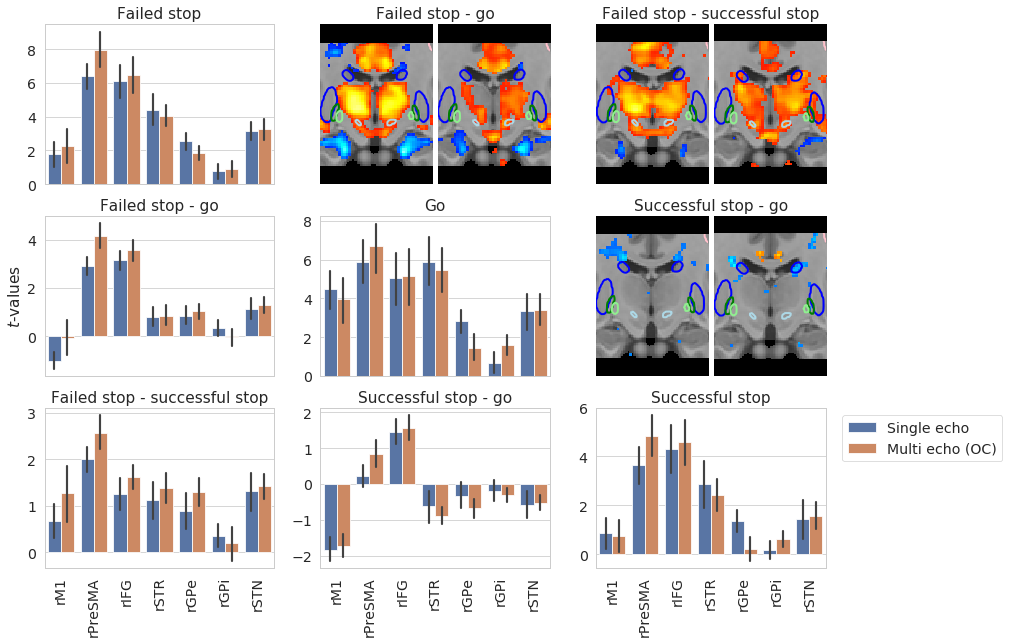

In [255]:
# Change font size
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
# fontsize = 22
# font = {'family' : 'normal',
#         'weight': 'normal',
#         'size'   : 22}
# matplotlib.rc('font', **font)
# matplotlib.rc('axes', titlesize=fontsize)

sns.set_context("paper", font_scale=1.60)


f, axes = plt.subplots(3, 3)
gs0 = gridspec.GridSpec(3, 3, figure=f)
cm = plt.get_cmap('Pastel2')
#norm = colors.Normalize(vmin=0, vmax=2)
title_bgcolors = {'Failed stop - successful stop': cm(0), 
                  'Failed stop - go': cm(3), 
                  'Successful stop - go': cm(4)}

location_dict = {'Failed stop': [0, 0],
                 'Go': [1, 1],
                 'Successful stop': [2, 2],
                 
                 'Failed stop - go': [1, 0],
                 'Failed stop - successful stop': [2, 0],
                 'Successful stop - go': [2, 1]}

for contrast, loc in location_dict.items(): 
    ax = axes[loc[0], loc[1]]
    sns.barplot(x='ROI', y='t', hue='Data', ax=ax, order=plot_masks, 
                data=t_vals_long.loc[np.in1d(t_vals_long.Event, contrast) &
                                     np.in1d(t_vals_long.ROI, plot_masks) & 
                                     np.in1d(t_vals_long.Data, ['Single echo', 'Multi echo (OC)'])], 
                ci=67)
    if contrast in ['Failed stop - go', 'Failed stop - successful stop', 'Successful stop - go']:
        ax.set_title(contrast)
    else:
        ax.set_title(contrast)

leg = axes.ravel()[-1].legend(loc=1, bbox_to_anchor=[1.8, 1])
leg.set_title('')

for i, ax_ in enumerate(axes.ravel()):
    if i < (len(axes.ravel())-1):
        ax_.legend().set_visible(False)
    ax_.set_xlabel('')
    ax_.set_ylabel('')
axes[1,0].set_ylabel('$t$-values')

for row in [0,1]:
    for col in [0, 1, 2]:
        axes[row, col].tick_params(axis='x',          # changes apply to the x-axis
                                   which='both',      # both major and minor ticks are affected
                                   bottom=False,      # ticks along the bottom edge are off
                                   top=False,         # ticks along the top edge are off
                                   labelbottom=False) # labels along the bottom edge are off
for col in [0, 1, 2]:
    axes[2, col].tick_params(axis='x', which='both', rotation=90)
# turn off other axes to remove background grid
axes[0, 1].axis('Off')
axes[0, 1].set_title('Failed stop - go')
axes[0, 2].axis('Off')
axes[0, 2].set_title('Failed stop - successful stop')
axes[1, 2].axis('Off')
axes[1, 2].set_title('Successful stop - go')

# plot SPMs
gs01 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0,1], wspace=0.05)
ax01_0 = plt.Subplot(f, gs01[0])
f.add_subplot(ax01_0)
disp = plot_spm(zmaps_combined[0], threshold=thresholds_combined[0], axes=ax01_0)
add_rois(disp, roi_dict=roi_map)
fix_lims(disp)

ax01_1 = plt.Subplot(f, gs01[1])
f.add_subplot(ax01_1)
disp = plot_spm(zmaps_combined[1], threshold=thresholds_combined[1], axes=ax01_1)
add_rois(disp, roi_dict=roi_map)
fix_lims(disp)

gs02 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0,2], wspace=0.05)
ax02_0 = plt.Subplot(f, gs02[0])
f.add_subplot(ax02_0)
disp = plot_spm(zmaps_combined[4], threshold=thresholds_combined[4], axes=ax02_0)
add_rois(disp, roi_dict=roi_map)
fix_lims(disp)
ax02_1 = plt.Subplot(f, gs02[1])
f.add_subplot(ax02_1)
disp = plot_spm(zmaps_combined[5], threshold=thresholds_combined[5], axes=ax02_1)
add_rois(disp, roi_dict=roi_map)
fix_lims(disp)


gs12 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[1,2], wspace=0.05)
ax12_0 = plt.Subplot(f, gs12[0])
f.add_subplot(ax12_0)
disp = plot_spm(zmaps_combined[2], threshold=thresholds_combined[2], axes=ax12_0)
add_rois(disp, roi_dict=roi_map)
fix_lims(disp)
ax12_1 = plt.Subplot(f, gs12[1])
f.add_subplot(ax12_1)
disp = plot_spm(zmaps_combined[3], threshold=thresholds_combined[3], axes=ax12_1)
add_rois(disp, roi_dict=roi_map)
fix_lims(disp)

f.set_size_inches(14, 10)
f.savefig('figures/figure5.pdf', bbox_inches='tight')

# Is there a correlation between $\Delta{t} / {TE}$ and $T_2^{*}$?

#### Estimate $T_2^{*}$

In [10]:
# Get timeseries per echo
ses_ts_raw = [get_session_timeseries('echo_1', standardize=False, drop_label=False), 
              get_session_timeseries('echo_2', standardize=False, drop_label=False), 
              get_session_timeseries('echo_3', standardize=False, drop_label=False)]
ses_ts_raw = pd.concat(ses_ts_raw, axis=0)
ses_ts_raw = ses_ts_raw.reset_index().melt(id_vars=['subject', 'session', 'run', 'time'], 
                                           var_name='roi', value_name='signal')

In [182]:
import numpy as np

def fit_monoexp_decay(x, tes=[9.66, 24.87, 40.08]):
#     print(x)
    # dep var y, log-space
    log_signal = np.log(x['signal'].values).reshape(3,1)
    
    # design matrix X
    intercept = np.ones((3,1))
    X = np.hstack([intercept, -np.array(tes).reshape((3,1))])
    
    # fit OLS
    fit = np.linalg.lstsq(X, log_signal)
    
    # back to normal space
    beta = fit[0]
    s0 = np.exp(beta[0])
    t2star = 1/beta[1]
    return pd.Series({'s0': s0, 't2s': t2star})

def mean_across_timeseries(x):
    return pd.Series({'s0': np.mean(x['s0']),
                      't2s': np.mean(x['t2s'])})

# get t2* estimate per volume
t2s = ses_ts_raw.groupby(['subject', 'run', 'roi', 'time']).apply(lambda x: fit_monoexp_decay(x))

# ...mean across timeseries...
t2s_roiwise = t2s.reset_index().drop(columns='time').groupby(['subject', 'run', 'roi']).apply(mean_across_timeseries)

# ...mean across runs
t2s_roiwise = t2s_roiwise.reset_index().groupby(['subject', 'roi']).apply(mean_across_timeseries)

# extract numeric
t2s_roiwise = t2s_roiwise.reset_index()
t2s_roiwise['s0'] = t2s_roiwise['s0'].apply(lambda x: x[0])
t2s_roiwise['t2s'] = t2s_roiwise['t2s'].apply(lambda x: x[0])

# what are the t2*-values?
t2s_roiwise.groupby('roi')['s0', 't2s'].mean()

# s0 is remarkably high for STN? Something with the application of the mask/extracting timeseries after all? 
# Although T2* is fine...

,s0,t2s
roi,,
ACC,3554.234960,33.782000
M1,4004.397884,31.617831
THA,2348.129961,27.072756
lGPe,2171.351682,12.117491
lGPi,3025.497683,17.654340
lM1,1026.514082,43.020484
lPreSMA,1960.527685,34.405198
lSTN,8772.001767,15.397410
lSTR,2527.381612,22.497721


In [ ]:
## t2s_roiwise contains T2*-estimates per ROI
## Next, we fit linear functions of $t$-value ~ TE

In [209]:
def fit_linear(x, tes=[9.66, 24.87, 40.08]):
    """ Fits a linear model, estimating t ~ TE. We're interested the slope here: dt/te"""
    # design matrix X
    intercept = np.ones((3,1))
    X = np.hstack([intercept, np.array(tes).reshape((3,1))])
    
    # fit OLS
    fit = np.linalg.lstsq(X, x['t'])[0]
    return pd.Series({'intercept': fit[0], 'dt_te': fit[1]})
    
lin_model = t_vals_long.loc[np.in1d(t_vals_long.Data, 
                                    ['Echo 1', 'Echo 2', 'Echo 3'])].groupby(['subject', 'Event', 'ROI']).apply(lambda x: fit_linear(x))

# For statistics, only test the "Failed stop vs baseline" contrast, and only include the masks of interest
lin_model = lin_model.reset_index().loc[(lin_model.reset_index()['Event'] == 'Failed stop') & 
                                        (np.in1d(lin_model.reset_index()['ROI'], plot_masks))]

# Merge linear model parameter estimates with T2* estimates
t2s_dt_te_df = pd.merge(lin_model, t2s_roiwise.rename(columns={'roi': 'ROI'}), 
                        on=['subject', 'ROI'])

In [210]:
def fit_linear_2(x):
    """ Fits a linear model, estimating dt/te ~ T2s"""
    y = x['dt_te'].values[:,np.newaxis]
    intercept = np.ones_like(y)
    X = np.hstack([intercept, x['t2s'].values[:,np.newaxis]])
    
    fit = np.linalg.lstsq(X, y)[0]
    return pd.Series({'intercept_0': fit[0], 'dt_te_t2s': fit[1]})

t2s_slope_df_level2 = t2s_dt_te_df.reset_index().groupby(['subject']).apply(fit_linear_2)
t2s_slope_df_level2['intercept_0'] = t2s_slope_df_level2['intercept_0'].apply(lambda x: x[0])
t2s_slope_df_level2['dt_te_t2s'] = t2s_slope_df_level2['dt_te_t2s'].apply(lambda x: x[0])
t2s_slope_df_level2.head()

,intercept_0,dt_te_t2s
subject,,
01,-0.031996,0.001095
02,-0.175988,0.006597
03,-0.200507,0.008403
04,-0.035166,0.001371
05,-0.126361,0.006042


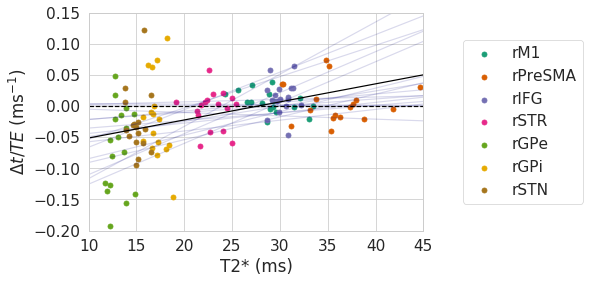

In [228]:
# Make plot of the correlation slope ~ T2*
from matplotlib import colors
f, ax = plt.subplots(1, 1)
xs = np.arange(0, 50, 1)
norm = colors.Normalize(vmin=0, vmax=t2s_dt_te_df.ROI.unique().shape[0])

# points per ROI, so we can color
for i, ROI in enumerate(plot_masks):
    t2s_this_roi = t2s_dt_te_df.loc[t2s_dt_te_df.ROI==ROI]
    ax.scatter(t2s_this_roi['t2s'], t2s_this_roi['dt_te'], 
               color=plt.get_cmap('Dark2')(norm(i)), 
               label=ROI, s=25)

# add individual regression lines
for sub in range(t2s_slope_df_level2.shape[0]):
    int_, beta = t2s_slope_df_level2.iloc[sub]
    ax.plot(xs, int_+beta*xs, alpha=0.15, color='navy')

# mean reg line
int_overall, slope_overall = t2s_slope_df_level2.mean()
ax.plot(xs, int_overall+slope_overall*xs, color='black')
ax.axhline(0, color='black', linestyle='--')

# labels, legend
ax.set_xlabel('T2* (ms)')
ax.set_ylabel('$\Delta{t} / {TE}$ (ms$^{-1}$)')
ax.set_ylim([-0.2, 0.15])
ax.set_xlim([10, 45])
ax.legend(loc=5, bbox_to_anchor=[1.5, .5])

# test for slope effect
stats.ttest_1samp(t2s_slope_df_level2['dt_te_t2s'], popmean=0)
f.savefig('figures/figure6.pdf', bbox_inches='tight')

## Finally, what would the conclusions be from each ROI-wise GLM?

In [261]:
# Get MC-corrected p-values for each of the contrasts of interest, for both the OC and SE data
pe_differences_long = pes_long.loc[np.in1d(pes_long['Event'], ['Failed stop - successful stop', 'Failed stop - go', 'Successful stop - go']) &
                                   np.in1d(pes_long['ROI'], plot_masks)]
pe_differences_long['Contrast'] = pe_differences_long['Event']
pe_differences_long['Value'] = pe_differences_long['pe']
p_vals_pe = pe_differences_long.groupby(['Data', 'ROI', 'Contrast'])['Value'].apply(lambda x: pd.Series({'t': stats.ttest_1samp(x, popmean=0)[0],
                                                                                             'p': stats.ttest_1samp(x, popmean=0)[1]}))
p_vals_pe = p_vals_pe.reset_index().pivot_table(values='Value', index=['Data', 'ROI', 'Contrast'], columns='level_3').reset_index()

# separate FDR correction for the OC and SE data
p_vals_oc = p_vals_pe.loc[p_vals_pe['Data'] == 'Multi echo (OC)'].reset_index()
p_vals_se = p_vals_pe.loc[p_vals_pe['Data'] == 'Single echo'].reset_index()

# multiple comparisons correction
p_vals_oc['p_corrected'] = multicomp.fdrcorrection0(p_vals_oc['p'])[1]
p_vals_se['p_corrected'] = multicomp.fdrcorrection0(p_vals_se['p'])[1]

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [266]:
print("All significant contrasts of the OC data (after MC correction):")
display(p_vals_oc.loc[p_vals_oc['p_corrected'] < 0.05])

print("All significant contrasts of the single echo data (after MC correction):")
display(p_vals_se.loc[p_vals_se['p_corrected'] < 0.05])

All significant contrasts of the OC data (after MC correction):


level_3,index,Data,ROI,Contrast,p,t,p_corrected
0,63,Multi echo (OC),rGPe,Failed stop - go,2.531997e-02,2.466537,0.037980
1,64,Multi echo (OC),rGPe,Failed stop - successful stop,6.601918e-03,3.119682,0.012604
2,65,Multi echo (OC),rGPe,Successful stop - go,1.927191e-02,-2.601757,0.033726
6,69,Multi echo (OC),rIFG,Failed stop - go,1.618708e-05,6.071481,0.000168
7,70,Multi echo (OC),rIFG,Failed stop - successful stop,2.557821e-04,4.670663,0.001074
8,71,Multi echo (OC),rIFG,Successful stop - go,1.117703e-03,3.962082,0.003353
11,74,Multi echo (OC),rM1,Successful stop - go,1.103612e-04,-5.084704,0.000579
12,75,Multi echo (OC),rPreSMA,Failed stop - go,9.549687e-07,7.669167,0.000020
13,76,Multi echo (OC),rPreSMA,Failed stop - successful stop,2.397183e-05,5.864195,0.000168
14,77,Multi echo (OC),rPreSMA,Successful stop - go,2.405579e-02,2.492049,0.037980


All significant contrasts of the single echo data (after MC correction):


level_3,index,Data,ROI,Contrast,p,t,p_corrected
6,90,Single echo,rIFG,Failed stop - go,9.382672e-07,7.679773,0.000010
7,91,Single echo,rIFG,Failed stop - successful stop,8.953779e-03,2.973894,0.031338
8,92,Single echo,rIFG,Successful stop - go,3.003378e-03,3.493679,0.012614
9,93,Single echo,rM1,Failed stop - go,1.949083e-02,-2.596195,0.045479
11,95,Single echo,rM1,Successful stop - go,6.569866e-04,-4.215409,0.003449
12,96,Single echo,rPreSMA,Failed stop - go,9.551450e-07,7.669056,0.000010
13,97,Single echo,rPreSMA,Failed stop - successful stop,1.644642e-05,6.063031,0.000115
15,99,Single echo,rSTN,Failed stop - go,1.531284e-02,2.714418,0.040196
16,100,Single echo,rSTN,Failed stop - successful stop,1.433737e-02,2.746482,0.040196


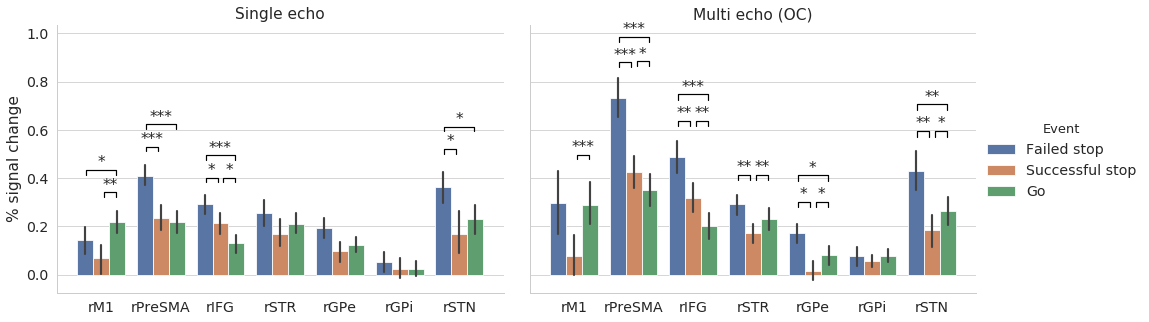

In [265]:
# Parameter estimates
# index ROIs, data types
data_to_plot = pes_long.loc[np.in1d(pes_long.ROI, plot_masks) & np.in1d(pes_long.Data, ['Single echo', 'Multi echo (OC)'])]

g = sns.catplot(x='ROI', y='pe', hue='Event', col='Data', 
                order=plot_masks, hue_order=['Failed stop', 'Successful stop', 'Go'],
                data=data_to_plot, 
                kind='bar', ci=67, aspect=1.4)
g.set_axis_labels("", "% signal change").set_titles("{col_name}")

# Get means & standard errors, useful for creating those brackets with statistics
mns = data_to_plot.groupby(['Data', 'ROI', 'Event']).pe.mean()
ses = data_to_plot.groupby(['Data', 'ROI', 'Event']).pe.apply(lambda x: np.std(x)/np.sqrt(len(x)))

# loop over ROIs
for i, ROI in enumerate(plot_masks):
    p_vals_this_roi = p_vals_se.loc[(p_vals_se['ROI'] == ROI), 'p_corrected'].values
    
    n_sign = 0
    if p_vals_this_roi[1] < 0.05:
        barplot_annotate_brackets(0, 1, p_vals_this_roi[1], [-.25+i, -.05+i, .25+i], 
                                  [mns[('Single echo', ROI)].max()] * 3, 
                                  yerr=[ses[('Single echo', ROI)].values.max()] * 3, 
                                  ax=g.axes[0,0], barh=0.02)
        n_sign += 1
    if p_vals_this_roi[2] < 0.05:
        barplot_annotate_brackets(1, 2, p_vals_this_roi[2], [-.25+i, .05+i, .25+i], 
                                  [mns[('Single echo', ROI)].max()] * 3, 
                                  yerr=[ses[('Single echo', ROI)].values.max()] * 3,
                                  ax=g.axes[0,0], barh=0.02)
        n_sign += 1
    if p_vals_this_roi[0] < 0.05:
        barplot_annotate_brackets(0, 2, p_vals_this_roi[0], [-.25+i, 0+i, .25+i], 
                                  [mns[('Single echo', ROI)].max()] * 3, 
                                  yerr=[ses[('Single echo', ROI)].values.max()] * 3,
                                  ax=g.axes[0,0], dh = 0.15*(n_sign>0), barh=0.02)

# again, now ME
for i, ROI in enumerate(plot_masks):
    p_vals_this_roi = p_vals_oc.loc[(p_vals_oc['ROI'] == ROI), 'p_corrected'].values
    
    n_sign = 0
    if p_vals_this_roi[1] < 0.05:
        barplot_annotate_brackets(0, 1, p_vals_this_roi[1], [-.25+i, -.05+i, .25+i], 
                                  [mns[('Multi echo (OC)', ROI)].max()] * 3, 
                                  yerr=[ses[('Multi echo (OC)', ROI)].values.max()] * 3, 
                                  ax=g.axes[0,1], barh=0.02)
        n_sign += 1
    if p_vals_this_roi[2] < 0.05:
        barplot_annotate_brackets(1, 2, p_vals_this_roi[2], [-.25+i, .05+i, .25+i], 
                                  [mns[('Multi echo (OC)', ROI)].max()] * 3, 
                                  yerr=[ses[('Multi echo (OC)', ROI)].values.max()] * 3,
                                  ax=g.axes[0,1], barh=0.02)
        n_sign += 1
    if p_vals_this_roi[0] < 0.05:
        barplot_annotate_brackets(0, 2, p_vals_this_roi[0], [-.25+i, 0+i, .25+i], 
                                  [mns[('Multi echo (OC)', ROI)].max()] * 3, 
                                  yerr=[ses[('Multi echo (OC)', ROI)].values.max()] * 3,
                                  ax=g.axes[0,1], dh = 0.15*(n_sign>0), barh=0.02)

plt.gcf().savefig('figures/figure7.pdf', bbox_inches='tight')